<a href="https://colab.research.google.com/github/Miguel123448/estatistica_psf/blob/main/C%C3%B3pia_de_C%C3%B3pia_de_Untitled3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
!pip install tmdbv3api scikit-learn nltk

import re
import nltk
import random
from nltk.corpus import stopwords
from tmdbv3api import TMDb, Movie, Genre, Discover
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

nltk.download('stopwords')

tmdb = TMDb()
tmdb.api_key = "e08af49bb0a5aac812535435d27024ed"
tmdb.language = "pt-BR"

movie_api = Movie()
genre_api = Genre()
discover_api = Discover()

genero_dict = {g['id']: g['name'] for g in genre_api.movie_list()}

def coletar_dados():
    sinopses = []
    generos_filmes = []

    for genero_id, genero_nome in genero_dict.items():
        print(f"Coletando dados para o gênero: {genero_nome}...")
        contador = 0
        pagina = 1

        while contador < 200:
            filmes = discover_api.discover_movies({"with_genres": genero_id, "page": pagina})
            for filme in filmes:
                if filme.overview and contador < 200:
                    sinopses.append(filme.overview)
                    generos_filmes.append(genero_nome)
                    contador += 1
            pagina += 1

    return sinopses, generos_filmes

sinopses, generos_filmes = coletar_dados()

def preprocessar_texto(texto):
    stop_words = set(stopwords.words('portuguese'))
    texto = re.sub(r'[^\w\s]', '', texto.lower())
    return ' '.join([palavra for palavra in texto.split() if palavra not in stop_words])

sinopses_limpas = [preprocessar_texto(s) for s in sinopses]

X_treino, X_teste, y_treino, y_teste = train_test_split(sinopses_limpas, generos_filmes, test_size=0.2, random_state=42)

modelo = make_pipeline(TfidfVectorizer(max_features=5000, ngram_range=(1,2)), MultinomialNB())
modelo.fit(X_treino, y_treino)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Coletando dados para o gênero: Ação...
Coletando dados para o gênero: Aventura...
Coletando dados para o gênero: Animação...
Coletando dados para o gênero: Comédia...
Coletando dados para o gênero: Crime...
Coletando dados para o gênero: Documentário...
Coletando dados para o gênero: Drama...
Coletando dados para o gênero: Família...
Coletando dados para o gênero: Fantasia...
Coletando dados para o gênero: História...
Coletando dados para o gênero: Terror...
Coletando dados para o gênero: Música...
Coletando dados para o gênero: Mistério...
Coletando dados para o gênero: Romance...
Coletando dados para o gênero: Ficção científica...
Coletando dados para o gênero: Cinema TV...
Coletando dados para o gênero: Thriller...
Coletando dados para o gênero: Guerra...
Coletando dados para o gênero: Faroeste...


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('multinomialnb', MultinomialNB())])

In [ ]:
#SINOPSE DE NADA DE NOVO NO FRONT
nova_sinopse = ["O adolescente Paul é convocado para atuar na linha de frente da Primeira Guerra Mundial. O jovem começa seu serviço militar de forma idealista e entusiasmada, mas logo é confrontado pela dura realidade do combate."]
genero_previsto = modelo.predict([preprocessar_texto(nova_sinopse[0])])

print("Gênero previsto:", genero_previsto[0])

Gênero previsto: Guerra


Abaixo, pegaremos uma quantidade fixa de 2000 sinopses e testaremos qual a porcentagem de acerto do modelo e qual porcentagem de erro do mesmo.

In [ ]:
def coletar_sinopses_aleatorias(qtd=2000):
    sinopses_aleatorias = []
    generos_reais = []
    pagina = 1
    contador = 0

    while contador < qtd:
        filmes = discover_api.discover_movies({"page": pagina})
        for filme in filmes:
            if filme.overview and contador < qtd:
                sinopses_aleatorias.append(filme.overview)
                generos_reais.append([genero_dict[g] for g in filme.genre_ids if g in genero_dict])
                contador += 1
        pagina += 1

    return sinopses_aleatorias, generos_reais

sinopses_teste, generos_reais = coletar_sinopses_aleatorias()

sinopses_teste_limpas = [preprocessar_texto(s) for s in sinopses_teste]

generos_previstos = modelo.predict(sinopses_teste_limpas)

acertos = 0
for i in range(len(generos_previstos)):
    if generos_previstos[i] in generos_reais[i]:
        acertos += 1

precisao = acertos / len(generos_previstos) * 100
print(f"Precisão do modelo em sinopses aleatórias: {precisao:.2f}%")


Precisão do modelo em sinopses aleatórias: 74.55%


ABAIXO TEMOS O GRÁFICO REFERENTE A QUANTIDADE DE FILMES ANALIZADOS E AS SUAS RESPECTIVAS PRECISÕES

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import collections
from collections import defaultdict
import pandas as pd
import seaborn as sns

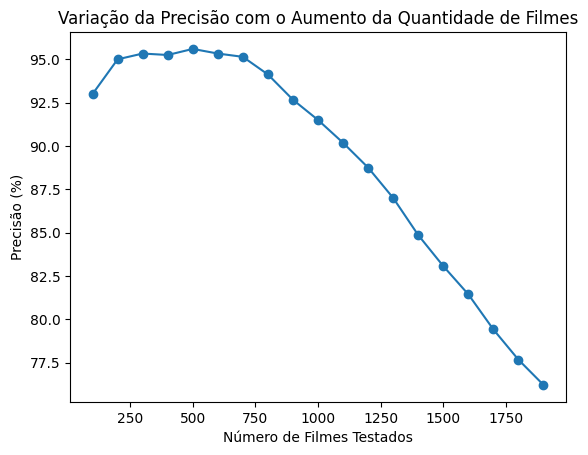

In [ ]:
num_filmes_testados = np.arange(100, 2000, 100)
precisoes = []

for n in num_filmes_testados:
    sinopses_teste_limpas_parcial = sinopses_teste_limpas[:n]
    generos_previstos_parcial = modelo.predict(sinopses_teste_limpas_parcial)
    acertos = sum([generos_previstos_parcial[i] in generos_reais[i] for i in range(n)])
    precisoes.append(acertos / n * 100)

plt.plot(num_filmes_testados, precisoes, marker='o')
plt.xlabel('Número de Filmes Testados')
plt.ylabel('Precisão (%)')
plt.title('Variação da Precisão com o Aumento da Quantidade de Filmes')
plt.show()

COMO NO TMDB TEMOS MUITOS FILMES DE AÇÃO A QUANTIDADE AO PEGAR ALEATÓRIAMENTE É MAIOR.

<ipython-input-27-fbdbd2a1ed68>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(contagem_generos.keys()), y=list(contagem_generos.values()), palette="viridis")


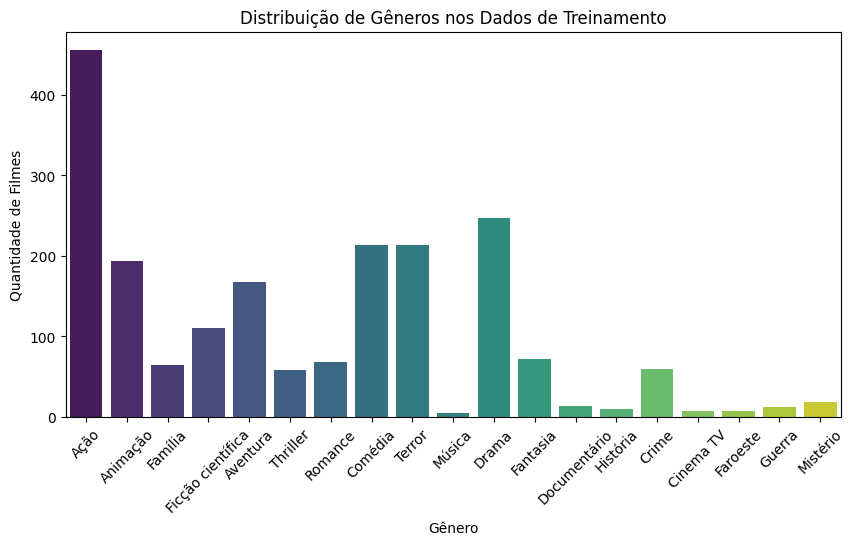

In [ ]:
contagem_generos = collections.Counter(y_true)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(contagem_generos.keys()), y=list(contagem_generos.values()), palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Gênero")
plt.ylabel("Quantidade de Filmes")
plt.title("Distribuição de Gêneros nos Dados de Treinamento")
plt.show()


MATRIZ DE CONFUSÃO QUE EXPRESSA OS ERROS. É NOTÓRIO UM PADRÃO, OS GÊNEROS MAIS PLURAIS COMO DRAMA, AÇÃO, ANIMAÇÃO, COMÉDIA E AVENTURA SÃO JOGADOS PARA OUTROS GÊNEROS. ENQUANTO GÊNEROS MAIS EXPECÍFICOS SÃO FACILMENTE RECONHECIDOS EX: MUSICAL E DOCUMENTÁRIO.


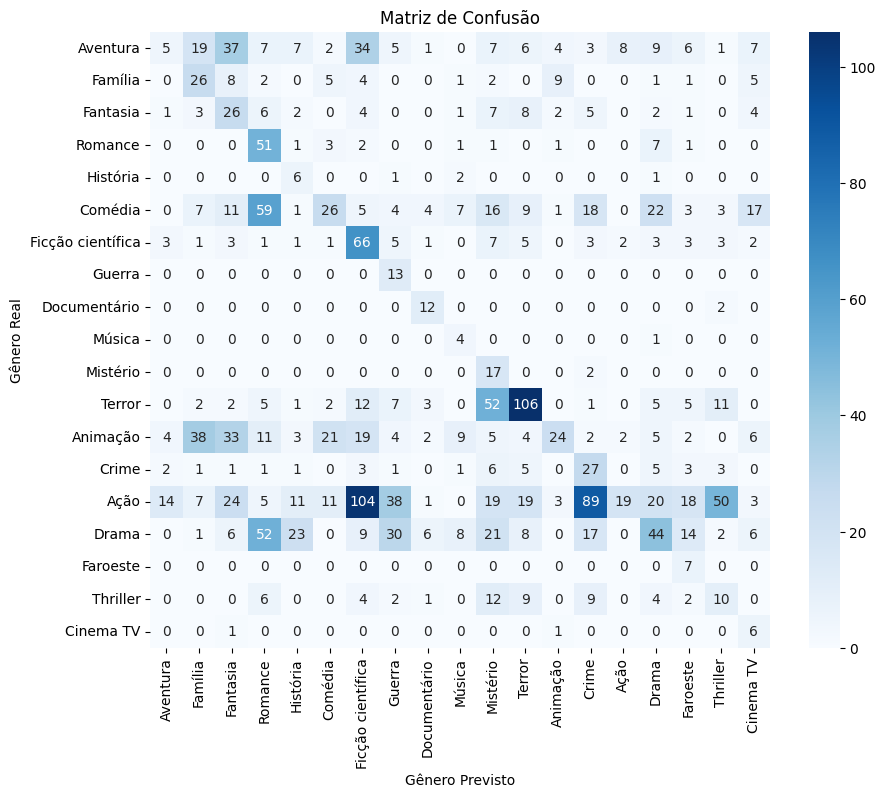

In [ ]:
generos_unicos = list(set(generos_previstos) | set(sum(generos_reais, [])))
y_true = [genero[0] for genero in generos_reais]
cm = confusion_matrix(y_true, generos_previstos, labels=generos_unicos)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=generos_unicos, yticklabels=generos_unicos, cmap="Blues")
plt.xlabel("Gênero Previsto")
plt.ylabel("Gênero Real")
plt.title("Matriz de Confusão")
plt.show()


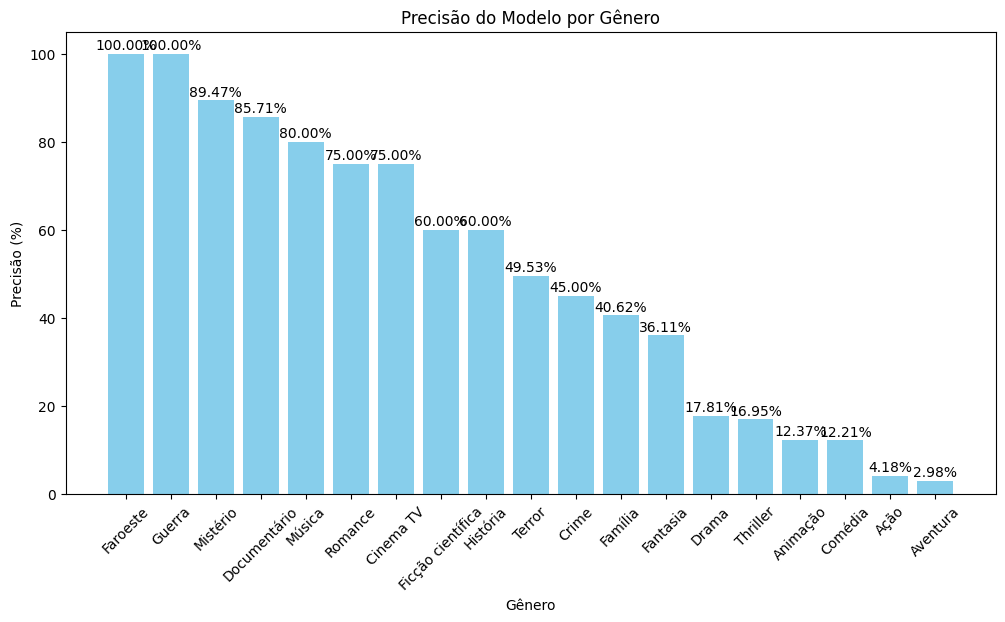

In [ ]:
acertos_por_genero = defaultdict(int)
total_por_genero = defaultdict(int)

for i in range(len(generos_previstos)):
    genero_real = generos_reais[i][0]
    genero_previsto = generos_previstos[i]

    total_por_genero[genero_real] += 1
    if genero_previsto == genero_real:
        acertos_por_genero[genero_real] += 1

precisao_por_genero = {g: (acertos_por_genero[g] / total_por_genero[g]) * 100 for g in total_por_genero}

generos_ordenados = sorted(precisao_por_genero, key=precisao_por_genero.get, reverse=True)

plt.figure(figsize=(12, 6))
plt.bar(generos_ordenados, [precisao_por_genero[g] for g in generos_ordenados], color='skyblue')

plt.xlabel("Gênero")
plt.ylabel("Precisão (%)")
plt.title("Precisão do Modelo por Gênero")
plt.xticks(rotation=45)

for i, genero in enumerate(generos_ordenados):
    plt.text(i, precisao_por_genero[genero] + 1, f"{precisao_por_genero[genero]:.2f}%", ha='center')

plt.show()


POSSIVEL SOLUÇÃO PARA REVERTER IMPRECISÃO, REALOCAR GÊNERO MAIS EXPECÍFICOS E GêNEROS PLURAIS EX: FAROESTE, CRIME, THRILLER, GUERRA REALOCADOS PARA AÇÃO

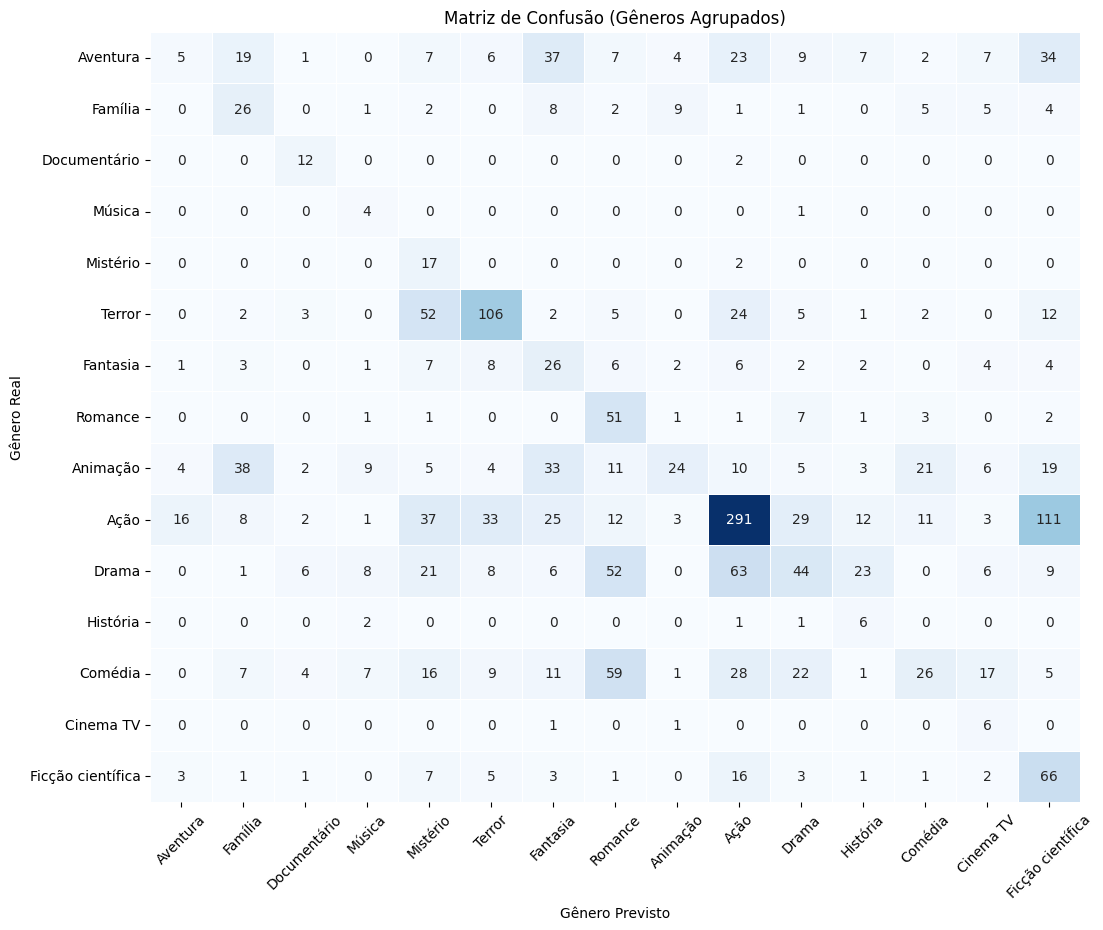

In [ ]:
generos_para_acao = {"Crime", "Guerra", "Faroeste", "Thriller"}

y_true_ajustado = ["Ação" if genero in generos_para_acao else genero for genero in y_true]
generos_previstos_ajustado = ["Ação" if genero in generos_para_acao else genero for genero in generos_previstos]

generos_unicos_ajustado = list(set(y_true_ajustado) | set(generos_previstos_ajustado))

cm_ajustado = confusion_matrix(y_true_ajustado, generos_previstos_ajustado, labels=generos_unicos_ajustado)

df_cm_ajustado = pd.DataFrame(cm_ajustado, index=generos_unicos_ajustado, columns=generos_unicos_ajustado)

plt.figure(figsize=(12, 10))
sns.heatmap(df_cm_ajustado, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5)
plt.xlabel("Gênero Previsto")
plt.ylabel("Gênero Real")
plt.title("Matriz de Confusão (Gêneros Agrupados)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()
